**In this notebook I want to construct a neural architecture to develop classifiers for the authors of short phrases by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL)**

For this I will use different models....




---



for csv look at data 

det er det som den skal spytte ud 

eksperiementer med forskellige modeller 

random forrest 
neural network ... simple og complex

se hvad der gør bedst 



---




Easy text-preprocessing approaches
Spacy and out of the box sentence embeddings
SKlearn and ML-style count-tfidf-vectorizer

In [1]:
# Import libraries

import pandas as pd
import numpy as np

import spacy

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# quick evaluation
from sklearn.metrics import classification_report



import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize

# Imporr libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk # the natural langauage toolkit, open-source NLP
from sklearn.neural_network import MLPClassifier

# Surpress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#!conda install -c conda-forge spacy
import spacy

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

# quick evaluation
from sklearn.metrics import classification_report

# Essential elements of Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

# Dropout layer
from keras.layers import Dropout

# Additional stuff: bells and whistles
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.preprocessing.sequence import pad_sequences

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


Using TensorFlow backend.


In [2]:
# Download the small standard English language model
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 3.9MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
# Load up the model, so we can use it

nlp = spacy.load('en')

In [0]:
# Load up the data

data = pd.read_csv('https://github.com/SDS-AAU/M3-2018/raw/master/assignments/individual/data/train.csv')

In [0]:
# take a 1000 sample (because it's an example)

data = data.sample(n=1000)

In [0]:
# If you run this just like that, it will take around 10min for the whole dataset

data['spacy_sentence_vec'] = data['text'].map(lambda t: nlp(t).vector)

In [7]:
# the spacy_sentence_vec column now contains a vector representation of each sentence with 384 dimensions

data.head()

,id,text,author,spacy_sentence_vec
3992,id07595,In the present case your application is the mo...,EAP,"[0.46331164, 0.3752259, 0.54843503, 2.2726707,..."
1319,id18046,"if so, had she any when found?",EAP,"[0.98625946, -1.3784728, 0.7315732, 0.91879344..."
12004,id17391,"I have spoken to you, Oinos, as to a child of ...",EAP,"[0.7904373, 0.65359515, 0.8918596, 0.8185714, ..."
5351,id20743,"Now he was no less a fanatic, but his desire t...",HPL,"[0.44771466, 0.076828614, 0.08537894, 1.165544..."
7153,id02040,But there is one pleasure still within the rea...,EAP,"[1.2325304, 0.31763524, -0.10880911, 1.1959221..."


In [0]:
# This is how we transform the sequence of lists in rows into a numpy array
# We just use vstack - that stands for vertical stacking

X = np.vstack(data['spacy_sentence_vec'])

In [9]:
# As expected: a 1000 by 384 matrix

X.shape

(1000, 384)

In [0]:
# our y can be defined from the author column using a standard label_encoder

y = labelencoder.fit_transform(data['author'])

# Random forrest classification
---



To have a baseline I start out by using a simple random forest classification model to be able to compare the results

In [0]:
# Split into train-test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [12]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 21)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

**Results from Random Forrest Classification model**

Here we see the results with a fairly good precision. lets check the next model. 


In [13]:
print(classification_report(y_test, classifier.predict(X_test), target_names=labelencoder.classes_))

             precision    recall  f1-score   support

        EAP       0.57      0.75      0.65        89
        HPL       0.52      0.29      0.38        51
        MWS       0.56      0.50      0.53        60

avg / total       0.55      0.56      0.54       200



#XGBoost Model
---
Now we will try with the XG Boost model


In [0]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
# Split into train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# fit model no training data
classifier = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
classifier.fit(X_train, y_train)

print(classifier)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=10, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)


In [16]:
# make predictions for test data
y_pred = classifier.predict(X_test)
predictions = [round(value) for value in y_pred]

# make predictions for test data
y_pred = classifier.predict(X_test)
predictions = [round(value) for value in y_pred]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**Results from XGBoost model**

In [17]:
print(classification_report(y_test, classifier.predict(X_test), target_names=labelencoder.classes_))

             precision    recall  f1-score   support

        EAP       0.62      0.73      0.67        89
        HPL       0.50      0.33      0.40        51
        MWS       0.57      0.58      0.58        60

avg / total       0.58      0.58      0.57       200



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The precission didnt improve much so maybe a linear way might not be the best way to approach this problem. Thefore I will try with artifical neural networks or more specifically recurrent neural networds


# Neural Net Architecture


---
??




In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True, 
                            smooth_idf=True)
X = vectorizer.fit_transform(data['text'])

In [0]:
# This can be added to reduce dimensionality (using SVC rather than PCA because of sparse matrix input)
# Dimensionality reduction (not really helpful)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=384, algorithm='randomized', n_iter=10, random_state=42)
X = svd.fit_transform(X)

In [0]:
# Import and instantiate the one hot encoder

from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder()

In [0]:
# Create the dummy-matrix and reshaping (actually the other way around)

y_matrix = one_hot_enc.fit_transform(y.reshape(-1,1))

In [0]:
#y = keras.utils.to_categorical(y, num_classes=3)

In [0]:
# Split into train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_matrix, test_size = 0.2, random_state = 42)

In [24]:
# Quick check of the created sets

print(X_train.shape)
print(y_train.shape)

(800, 384)
(800, 3)


In [25]:
# multi-class classification problem
model = Sequential()
model.add(Dense(384, activation='tanh', input_shape=(384,))),
model.add(Dense(15, activation='tanh')),
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=3)

# Fit the model
history = model.fit(X, y_matrix, validation_data=(X_test, y_test), epochs=250, callbacks=[early_stopping_monitor])

ValueError: ignored

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 384)               147840    
_________________________________________________________________
dense_5 (Dense)              (None, 15)                5775      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 48        
Total params: 153,663
Trainable params: 153,663
Non-trainable params: 0
_________________________________________________________________


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

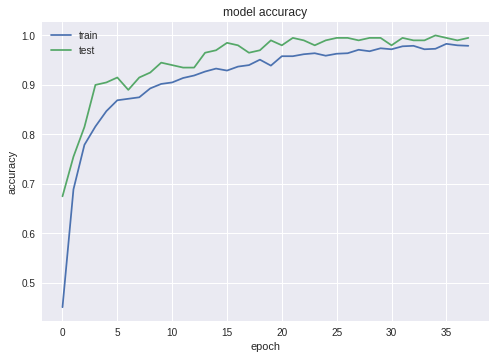

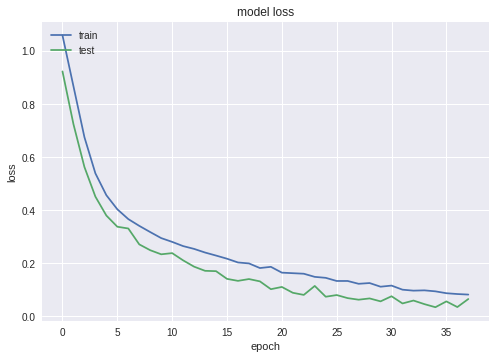

In [31]:
plt.style.use('seaborn')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# How does it perform?

model.evaluate(X,y)

1000/1000 [==============================] - 0s 67us/step


[0.07716008584201337, 0.988]

## Another neural net example


First we prepare output variable for the neural net model using one hot encoder

In [0]:
# Import and instantiate the one hot encoder

from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder()

In [0]:
# Create the dummy-matrix and reshaping (actually the other way around)

y_matrix = one_hot_enc.fit_transform(y.reshape(-1,1))

In [0]:
# Create new train and test-splits

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_matrix, test_size = 0.2, random_state = 42)

In [29]:
# Quick check of the created sets

print(X_train.shape)
print(y_train.shape)

(800, 384)
(800, 3)


Now we start with the neural net

In [0]:
# Importing the keras library for deep learning

# Essential elements of Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

# Dropout layer
from keras.layers import Dropout

# Additional stuff: bells and whistles
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [0]:
# As in Sklearn and other models we instatiate the classifier first (nothing new here)
classifier = Sequential() 

In [0]:
# From here we build up the network one layer at a time using the "add" method

#### Input Layer ####
classifier.add(Dense(units = 384, activation='relu', input_dim = 384))
classifier.add(Dropout(rate = 0.3))

#### Hidden ####
classifier.add(Dense(units = 384, activation='relu'))
classifier.add(Dropout(rate = 0.3))

#### Output ####
classifier.add(Dense(units = 3, activation='softmax'))

In [0]:
#### COMPILE ####
classifier.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
# Let's check out how our network looks like

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1155      
Total params: 296,835
Trainable params: 296,835
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The checkpointer is not necessary but useful, as it will save the best performing model for later use
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

In [36]:
# We train the model with the fit method (surprise). We specify some parameters: how many observations per batch, how many epochs to train
# the rest is optional but nice (calculate a test-set-performance score at each epoch, shuffle the observations in each batch as well as)
# use the callback which saves the best model.
history = classifier.fit(X_train, y_train, batch_size= 32, epochs= 250, validation_data=(X_test, y_test), shuffle=True,
                        callbacks=[checkpointer])

Train on 800 samples, validate on 200 samples
Epoch 1/250
800/800 [==============================] - 1s 1ms/step - loss: 1.0846 - acc: 0.4062 - val_loss: 1.0585 - val_acc: 0.4450
Epoch 2/250
800/800 [==============================] - 0s 320us/step - loss: 1.0220 - acc: 0.4175 - val_loss: 1.0216 - val_acc: 0.4500
Epoch 3/250
800/800 [==============================] - 0s 311us/step - loss: 0.8390 - acc: 0.6550 - val_loss: 0.9261 - val_acc: 0.5600
Epoch 4/250
800/800 [==============================] - 0s 323us/step - loss: 0.4892 - acc: 0.8788 - val_loss: 0.8637 - val_acc: 0.6000
Epoch 5/250
800/800 [==============================] - 0s 313us/step - loss: 0.2324 - acc: 0.9375 - val_loss: 0.9782 - val_acc: 0.6100
Epoch 6/250
800/800 [==============================] - 0s 311us/step - loss: 0.1157 - acc: 0.9788 - val_loss: 1.1040 - val_acc: 0.6000
Epoch 7/250
800/800 [==============================] - 0s 299us/step - loss: 0.0589 - acc: 0.9950 - val_loss: 1.2187 - val_acc: 0.6050
Epoch 8/250

In [0]:
# Let's plot our trainin process (we actually can look what happened as we were training)
import matplotlib.pyplot as plt

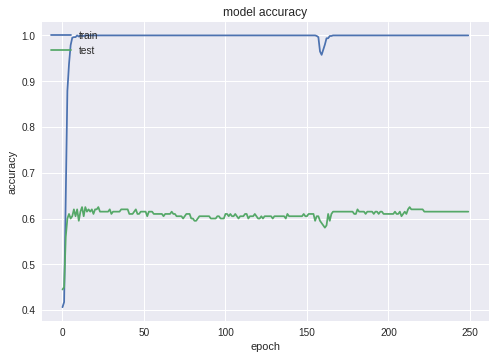

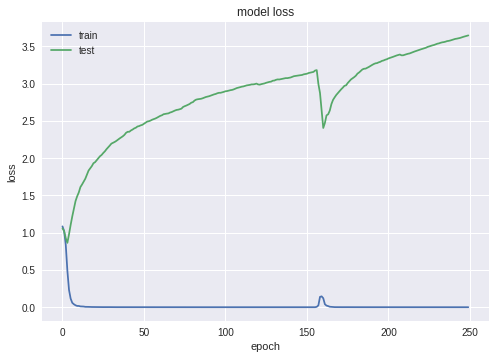

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# How does it perform?

classifier.evaluate(X_test,y_test)

200/200 [==============================] - 0s 140us/step


[3.6474600791931153, 0.615]

In [40]:
y_pred = model.predict(X_test)



y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.51      0.28      0.36        89
          1       0.28      0.41      0.34        51
          2       0.32      0.42      0.36        60

avg / total       0.40      0.35      0.36       200



In [41]:
# columns = predicted, rows = real

# y_test.A.ravel() is weird: we need to transform it from a matrix to an array and then flatten it back to a 1D vector.
pd.crosstab(labelencoder.inverse_transform(y_test.A.ravel()),labelencoder.inverse_transform(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


col_0,EAP,HPL,MWS
row_0,,,
EAP,25,31,33
HPL,11,21,19
MWS,13,22,25


something else

## Another neural net example 2


First we prepare output variable for the neural net model using one hot encoder

In [0]:
# Import and instantiate the one hot encoder

from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder()

In [0]:
# Create the dummy-matrix and reshaping (actually the other way around)

y_matrix = one_hot_enc.fit_transform(y.reshape(-1,1))

In [0]:
# Create new train and test-splits

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_matrix, test_size = 0.2, random_state = 42)

In [87]:
# Quick check of the created sets

print(X_train.shape)
print(y_train.shape)

(800, 384)
(800, 3)


Now we start with the neural net

In [0]:
# Importing the keras library for deep learning

# Essential elements of Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

# Dropout layer
from keras.layers import Dropout

# Additional stuff: bells and whistles
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [0]:
# As in Sklearn and other models we instatiate the classifier first (nothing new here)
classifier = Sequential() 

In [0]:
# From here we build up the network one layer at a time using the "add" method

#### Input Layer ####
classifier.add(Dense(units = 384, activation='relu', input_dim = 384))
classifier.add(Dropout(rate = 0.3))

#### Hidden ####
classifier.add(Dense(units = 100, activation='relu'))
classifier.add(Dropout(rate = 0.3))

#### Output ####
classifier.add(Dense(units = 3, activation='softmax'))

In [0]:
#### COMPILE ####
classifier.compile(optimizer="rmsprop", loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [103]:
# Let's check out how our network looks like

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 384)               147840    
_________________________________________________________________
dropout_7 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               38500     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 303       
Total params: 186,643
Trainable params: 186,643
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The checkpointer is not necessary but useful, as it will save the best performing model for later use
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

In [105]:
# We train the model with the fit method (surprise). We specify some parameters: how many observations per batch, how many epochs to train
# the rest is optional but nice (calculate a test-set-performance score at each epoch, shuffle the observations in each batch as well as)
# use the callback which saves the best model.
history = classifier.fit(X_train, y_train, batch_size= 32, epochs= 250, validation_data=(X_test, y_test), shuffle=True,
                        callbacks=[checkpointer])

ValueError: ignored

In [0]:
# Let's plot our trainin process (we actually can look what happened as we were training)
import matplotlib.pyplot as plt

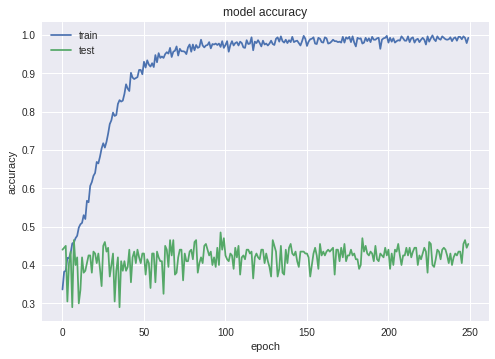

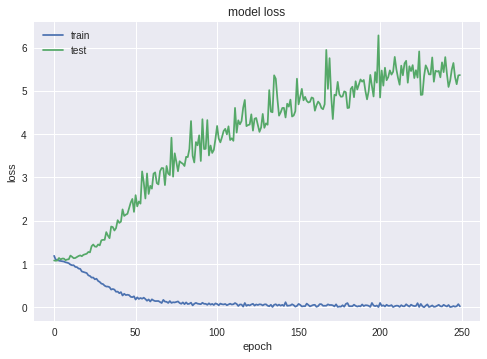

In [107]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
# How does it perform?

#classifier = load_model('model.h5')
classifier.evaluate(X_test,y_test)

ValueError: ignored

In [97]:
y_pred = model.predict(X_test)



y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.50      0.11      0.18        89
          1       0.25      0.02      0.04        51
          2       0.30      0.87      0.44        60

avg / total       0.37      0.32      0.22       200



In [109]:
# columns = predicted, rows = real

# y_test.A.ravel() is weird: we need to transform it from a matrix to an array and then flatten it back to a 1D vector.
pd.crosstab(labelencoder.inverse_transform(y_test.A.ravel()),labelencoder.inverse_transform(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


col_0,EAP,HPL,MWS
row_0,,,
EAP,10,1,78
HPL,4,1,46
MWS,6,2,52


In [0]:
# This will tokenize and count up each and any text-chunk
# Add a TFIDF transformer if you want to work from that end

#from sklearn.feature_extraction.text import CountVectorizer
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(data['text'])

# Results


In [0]:
test = pd.read_csv('https://github.com/SDS-AAU/M3-2018/raw/master/assignments/individual/data/test.csv')

In [63]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [0]:
#Activate this if it is for development purposes, otherwise it will take a long ass time
test = test[:1000]

Now we again have to vectorize each word so that all the words are represented by vectors. 

In [0]:
test['spacy_sentence_vec'] = test['text'].map(lambda t: nlp(t).vector)

In [66]:
test.head()

,id,text,spacy_sentence_vec
0,id02310,"Still, as I urged our leaving Ireland with suc...","[0.73991865, 0.16185702, 0.77799124, 0.7636164..."
1,id24541,"If a fire wanted fanning, it could readily be ...","[0.74620396, 0.14490844, -0.180486, 1.3279938,..."
2,id00134,And when they had broken down the frail door t...,"[0.67145103, -0.31144783, 0.45671213, 0.904057..."
3,id27757,While I was thinking how I should possibly man...,"[0.016066251, -0.07044156, 0.2711458, 0.92275,..."
4,id04081,I am not sure to what limit his knowledge may ...,"[0.43912992, 0.3072188, 1.2108351, 0.89780664,..."


Then we use the spacy package again to stack the data in the correct way. This will result in a nice matrix of the right data

In [0]:
X = np.vstack(test['spacy_sentence_vec'])

Next we predict the training data. This time we don't know if our results are correct or not - we can just see the results.

In [0]:
classifier = load_model('model.h5')

In [0]:
y_pred = classifier.predict(X)

Lets take a look at our results. They are in scientific notation, but no matter.

In [112]:
y_pred

array([[0.3413332 , 0.3246902 , 0.33397654],
       [0.36699244, 0.33418858, 0.29881904],
       [0.38760972, 0.27727765, 0.33511257],
       ...,
       [0.3781609 , 0.30353498, 0.31830406],
       [0.3734448 , 0.3228053 , 0.30374998],
       [0.39444172, 0.28689107, 0.3186672 ]], dtype=float32)

In [113]:
#Add the results to a dataframe 
my_results = pd.DataFrame({'EAP':y_pred[:,0],'HPL':y_pred[:,1],'MWS':y_pred[:,2]})

#Add the ID to the dataframe
my_results['id'] = test['id']

my_results.head()

,EAP,HPL,MWS,id
0,0.341,0.325,0.334,id02310
1,0.367,0.334,0.299,id24541
2,0.388,0.277,0.335,id00134
3,0.387,0.309,0.304,id27757
4,0.368,0.305,0.327,id04081


##Save results to .csv
We save the results in a csv file that can be downloaded from transfer.sh when you press the link that is generated. 

In [0]:
my_results.to_csv("Individual_assignment3_results.csv", sep=',')

In [78]:
!curl --upload-file Individual_assignment3_results.csv https://transfer.sh/my_results.csv

https://transfer.sh/k7CdI/my_results.csv